**Sample Code for our unimodal experiments with albert**

In [ ]:
# mount google drive to colab for dataset
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/DL_PROJECT or <Enter your gfolder location>')

Mounted at /content/drive


In [ ]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 8.3 MB/s 
     |████████████████████████████████| 3.3 MB 60.7 MB/s 
     |████████████████████████████████| 636 kB 73.4 MB/s 
     |████████████████████████████████| 895 kB 66.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install jsonlines

In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 7.5 MB/s 


In [ ]:
from PIL import Image
import jsonlines
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.utils import data
from torchvision import transforms, datasets, models
import matplotlib.pyplot as plt
import torch.optim as optim
from collections import defaultdict

#Load the ALBERT tokenizer - Make sure Sentencepiece is installed befire using this model
import transformers
from transformers import AlbertTokenizerFast #SqueezeBertTokenizerFast #DebertaTokenizerFast #BertTokenizer
tokenizer = AlbertTokenizerFast.from_pretrained('<appropriate albert version from huggingface.com>', do_lower_case=True) #albert-xxlarge-v2  #'albert-base-v2' #'albert-base-v1' #DebertaTokenizerFast

In [ ]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
# Tokenize all sentences; then map the tokens to their word IDs

def create_tokens(sequences):    
    input_ids = []
    attention_masks = []
    for seq in sequences:
        '''
        `encode_plus` will:
          (1) Tokenize the caption.
          (2) Prepend the `[CLS]` token to the start.
          (3) Append the `[SEP]` token to the end.
          (4) Map tokens to their IDs.
          (5) Pad or truncate the sentence to `max_length`
          (6) Create attention masks for [PAD] tokens.
        '''
        encoded_dict = tokenizer.encode_plus(
                            seq,                       # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 48,           # Pad & truncate all sentences.
                            truncation=True,
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt'      # Return pytorch tensors.
                       ) 
        input_ids.append(encoded_dict['input_ids'])   # ENCODED SENTENCES
        attention_masks.append(encoded_dict['attention_mask'])  # Respective attention mask (simply differentiates padding from non-padding).
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    return input_ids, attention_masks

In [ ]:
# Data Augmentation - Images are cropped or flipped based on weather we are using test/val or training set

class mytestdataset(): 

    def __init__(self, classification_list, name):
        super(mytestdataset).__init__()
        self.X = []
        self.Cap = []
        self.Imagename = []

        with jsonlines.open(classification_list) as f:
          f1 = []
          for line in f:
            f1.append(line)
          for line1 in f1:
            path =  line1['img']
            self.X.append('/content/drive/My Drive/<enter path of classification list to test>'+path)
            self.Cap.append(line1['text'])
            self.Imagename.append(line1['id'])
        
        #Tokenize all of the captions and map the tokens to their word IDs, and get respective attention masks.
        self.input_ids, self.attention_masks = create_tokens(self.Cap)
        
        # Data Augmentation - Input Image Transformation
        self.transform = transforms.Compose([   transforms.Resize(256),
                                                transforms.CenterCrop(224),               # Experiments with cropping - 224, 384, 256 
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                     std=[0.229, 0.224, 0.225])
                                            ])
    
    def __getitem__(self,index):
        image = self.X[index]       
        image = Image.open(image).convert('RGB')    #convert all images to 3 channels; there are images in the dataset that are 4 channels e.g. 'RGBA'
        image = self.transform(image)
        caption = self.Cap[index]
        input_id = self.input_ids[index]
        attention_masks = self.attention_masks[index]
        Imagename = self.Imagename[index]
        return image, caption, input_id, attention_masks, Imagename
        
    def __len__(self):
        return len(self.X)


class mydataset():    

    def __init__(self, classification_list, name):
        super(mydataset).__init__()
        self.X = []
        self.Cap = []
        self.Y = []
        with jsonlines.open(classification_list) as f:
          f1 = []
          for line in f:
            f1.append(line)
          for line1 in f1:
            path =  line1['img']
            self.X.append('/content/drive/My Drive/DL_PROJECT/<enter path of classification list to train/validate>'+path)
            self.Cap.append(line1['text'])
            self.Y.append(line1['label'])

        #Tokenize all of the captions and map the tokens to their word IDs, and get respective attention masks.
        self.input_ids, self.attention_masks = create_tokens(self.Cap)
        
        # Data Augmentation - Input Image Transformation
        if name in ['valid','test']:
            self.transform = transforms.Compose([transforms.Resize(384),
                                                 transforms.CenterCrop(256),   #Experiment with centre crop and crop sizes - 224,256,384
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                    std=[0.229, 0.224, 0.225])
                                                ])
        else:
            self.transform = transforms.Compose([transforms.Resize(256),
                                                 transforms.RandomCrop(224),
                                                transforms.RandomHorizontalFlip(),      #Experiment with flipping images - vertical, horizontal
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                    std=[0.229, 0.224, 0.225])
                                                                                            ])
    
    def __getitem__(self,index):
        #For Image and Label
        image = self.X[index]
        image = Image.open(image).convert('RGB') #convert all images to 3 channels; there are images in the dataset that are 4 channels e.g. 'RGBA'
        image = self.transform(image)
        label = float(self.Y[index])
        
        # Get Captions, Input ids and Attention mask
        caption = self.Cap[index]
        input_id = self.input_ids[index]
        attention_masks = self.attention_masks[index] 
        return image, caption, input_id, attention_masks, torch.as_tensor(label).long()

    def __len__(self):
        return len(self.X)

In [ ]:
# Codeblocks for Wide ResNet or RexNext
#Reference paper: "Deep residual learning for image recognition"https://arxiv.org/abs/1512.
#https://arxiv.org/abs/1706.02677
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
        self.dilation = 1   # experimenting with dilation
        self.inplanes = 64
        if replace_stride_with_dilation is None: # Tuple elements signifies if we should replace the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("Replace_stride_with_dilation should be a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        for unit in self.modules():
            if isinstance(unit, nn.Conv2d):
                nn.init.kaiming_normal_(unit.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(unit, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(unit.weight, 1)
                nn.init.constant_(unit.bias, 0)

        # Zero-initialize the last BN in each residual branch, so that the residual branch starts with zeros, and each residual block behaves like an identity. Reference: https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for unit in self.modules():
                if isinstance(unit, Bottleneck):
                    nn.init.constant_(unit.bn3.weight, 0)
                elif isinstance(unit, BasicBlock):
                    nn.init.constant_(unit.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)        
        embedding = x
        x = self.fc(embedding)
        return x, embedding

'''
def ResNet50(img_channels=3,num_classes=1000):
     """ResNet-50 model from
     `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
     Args:
         pretrained (bool): If True, returns a model pre-trained on ImageNet
         progress (bool): If True, displays a progress bar of the download to stderr
     """
     return ResNet(BasicBlock, [3, 4, 6, 3], img_channels,num_classes)

'''

def resnext101_32x8d(pretrained=False, progress=True, **kwargs):
    """ResNeXt-101 32x8d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 8
    return _resnet('resnext101_32x8d', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)
'''
def wide_resnet101_2(pretrained=False, progress=True, **kwargs):
      """Wide ResNet-101-2 model from
      `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`
      """
      kwargs['width_per_group'] = 64 * 2
      return _resnet('wide_resnet101_2', Bottleneck, [3, 4, 23, 3],
                      pretrained, progress, **kwargs) 
'''
def _resnet(arch, block, layers, pretrained, progress, **kwargs):
      model = ResNet(block, layers, **kwargs)
      if pretrained:
          state_dict = load_state_dict_from_url(model_urls[arch],
                                                progress=progress)
          model.load_state_dict(state_dict)
      return model

class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2) while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # Referencepaper: "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

In [ ]:
# Install Albert for pre-training model
from transformers import AlbertForPreTraining, AdamW, AlbertConfig, get_linear_schedule_with_warmup

**Device**

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


**Prepare for Dataloading Training, Validation datasets**

In [ ]:
import os
os.getcwd()

'/content/drive/MyDrive/DL_PROJECT'

In [ ]:
trainlist = '/content/drive/My Drive/DL_PROJECT/<train dataset>'
validlist = '/content/drive/My Drive/DL_PROJECT/<validation dataset>'

In [ ]:
#Train Dataloader
train_dataset = mydataset(trainlist,name='train')         
train_dataloader = data.DataLoader(train_dataset, shuffle= True, batch_size = 4, num_workers=2,pin_memory=True)

#Validation Dataloader
validation_dataset = mydataset(validlist, name='valid')        
validation_dataloader = data.DataLoader(validation_dataset, shuffle=False, batch_size = 4, num_workers=2,pin_memory=True)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


**Load Image Model**


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)
#Experiments with different combinations as follows:    
#Image_model = ResNet(Bottleneck, [3, 4, 6, 3], num_classes = 2)
Image_model = resnext101_32x8d()
#Image_model = wide_resnet101_2()
Image_model.fc = nn.Sequential(
    nn.Linear(Image_model.fc.in_features, 2)
    )
Image_model = nn.DataParallel(Image_model).to(device)

**Load Albert Model**

In [ ]:
Text_model = AlbertForPreTraining.from_pretrained(
    "<appropriate albert version from huggingface.com>", # albert-xxlarge-v2  #'albert-base-v2' #'albert-base-v1'
    num_labels = 2,   
    output_attentions = False, 
    output_hidden_states = True
)
Text_model = nn.DataParallel(Text_model).to(device)

In [ ]:
#Fusion - Image Features, Text Features with Batch Normalization+Dropout
class early_fusion(nn.Module):
    def __init__(self, num_classes, drop_prob = 0.1):
        super(FusionNet, self).__init__()
        self.fc = nn.Linear(in_features=768+2048, out_features= 512)
        self.bn = nn.BatchNorm1d(512)
        self.bn1 = nn.BatchNorm1d(768)    # These features will change in case of using xlarge and xxlarge versions of the selected tokenizer; 768 is for base version of BERT family tokenizers
        self.bn2 = nn.BatchNorm1d(2048)        
        self.dropout = nn.Dropout(drop_prob)   
        self.classify = nn.Linear(in_features = 512, out_features = num_classes)

    def forward(self, text_features, image_features):
        text_features = self.bn1(text_features)
        image_features = self.bn2(image_features)
        fused_input =  torch.cat((text_features, image_features), dim=1)
        x = self.fc(fused_input)
        x = F.relu(self.bn(x))        
        x = F.relu(self.classify(x)) 
        return x

In [ ]:
''' testing with loss graphs
def plot_loss(epochs, train_loss, valid_loss, title):
    plt.figure()
    x = np.arange(1,epochs+2)
    plt.plot(x, train_loss, label = 'Training Loss')
    plt.plot(x, valid_loss, label = 'Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
def plot_acc(epochs,valid_accuracy):
    plt.figure()
    x = np.arange(1,epochs+2)
    plt.plot(x, valid_accuracy)
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy v/s Epochs')
'''

In [ ]:
train_loss, valid_loss, valid_accuracy= [],[],[]

def train(image_model,text_model,fusion_model,data_loader,test_loader,criterion,optimizer, lr_scheduler, modelpath, writer, device, epochs):
    fusion_model.train()
    for epoch in range(epochs):
        avg_loss = 0.0 
        for batch_num, (feature, captions, input_id, attention_masks, target) in enumerate(data_loader):
            feature, target = feature.to(device), target.to(device)
            input_ids, attention_masks = input_id.to(device), attention_masks.to(device)
            # Get ResNet Features
            out, image_features = image_model(feature)
            # Get ResNet Features- Select hidden state corresponding to [CLS] token from the final transformer
            output_dictionary = text_model(input_ids, 
                                           #token_type_ids=None, 
                                           attention_mask=attention_masks, 
                                           labels=target,
                                           return_dict = True)
            text_features = output_dictionary.hidden_states[-1][:,0,:]
  
            #Output and loss from Fusion model
            output = fusion_model(text_features, image_features)
            loss = criterion(output, target)                 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
             
            del feature
            del captions
            del input_ids
            del attention_masks
            del target
            del loss
 
        training_loss = avg_loss/len(data_loader)
        print('Epoch: ', epoch+1)            
        print('training loss = ', training_loss)
        train_loss.append(training_loss)

        lr_scheduler.step() #linear_schedule_with_warmup take step after each batch
            
        # Validation Performance
        valid_loss, best_acc= test_classify(image_model, text_model, fusion_model, test_loader, criterion, device)
        valid_loss.append(valid_loss)
        valid_accuracy.append(best_acc)
        print("Loss/train", training_loss, epoch)            
        print('Loss/Validation', valid_loss, epoch)
        print('Accuracy/Validation', best_acc, epoch)
       
#Testing classification logic
def test_classify(image_model, text_model, fusion_model, test_loader, criterion, device):
    fusion_model.eval()
    image_model.eval()
    text_model.eval()
    test_loss = []
    best_accuracy = 0
    total = 0
    for batch_num, (feature, captions, input_id, attention_masks, target) in enumerate(test_loader):
        feature, target = feature.to(device), target.to(device)
        input_ids, attention_masks = input_id.to(device), attention_masks.to(device)
        
        out, image_features = image_model(feature)
        output_dictionary = text_model(input_ids, 
                                       token_type_ids=None, 
                                       attention_mask=attention_masks, 
                                       labels=target,
                                       return_dict = True)
        text_features = output_dictionary.hidden_states[-1][:,0,:]
        output = fusion_model(text_features, image_features)
        loss = criterion(output, target)
        test_loss.extend([loss.item()]*feature.size()[0])

        # Test prediction logic
        predictions = F.softmax(output, dim=1)
        _, best_pred_labels = torch.max(predictions,1)
        best_pred_labels = best_pred_labels.view(-1)
        best_accuracy += torch.sum(torch.eq(best_pred_labels, target)).item()
        total += len(target)
        
        del feature
        del captions
        del input_ids
        del attention_masks
        del target
        del loss
      
    fusion_model.train()
    return np.mean(test_loss), best_accuracy/total

In [ ]:
Fusion_model = early_fusion(num_classes = 2 , drop_prob = 0.06)
Fusion_model = nn.DataParallel(Fusion_model).to(device)

In [ ]:
model_name = 'Early Fusion Model'
model_path = '/content/drive/My Drive/DL_PROJECT/' +model_name

**Hyperparameter Tuning**

In [ ]:
num_Epochs = 50
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 4, gamma = 0.1)

#Loss Function
criterion = nn.CrossEntropyLoss()
#Optimizers - SGD only, SGD with momentum and AdamW
optimizer = torch.optim.SGD(Fusion_model.parameters(), lr=1e-3, weight_decay=1e-1, momentum=0.9)
#optimizer = AdamW(Fusion_model.parameters(), lr = 2e-3, eps = 1e-8)

# max_lr = 1.0
# lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, total_steps=None, epochs=num_Epochs, steps_per_epoch=len(train_dataloader), pct_start=0.1, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.89, max_momentum=0.99, div_factor=25.0, final_div_factor=10000.0, last_epoch=-1)
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max, eta_min=0, last_epoch=-1)


In [ ]:
torch.cuda.empty_cache()
from torch.utils.tensorboard import SummaryWriter   #  This is for tensorboard experiments
writer = SummaryWriter(model_name)
train(Image_model, Text_model, Fusion_model, train_dataloader, validation_dataloader, criterion, optimizer, lr_scheduler, model_path, writer, device, epochs = num_Epochs)
writer.flush()
writer.close()

**Evaluate**

**Make Predictions on Test and generate classification output in csv format**

**Test Dataloader**

In [ ]:
testlist = '/content/drive/My Drive/DL_PROJECT/<Enter location for your test dataset>.jsonl'

In [ ]:
test_dataset = mytestdataset(testlist, name='test')          
test_dataloader = data.DataLoader(test_dataset, shuffle= False, batch_size = 4, num_workers=2,pin_memory=True)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
import csv
def make_predictions(image_model, text_model, fusion_model, test_dataloader, device):
    image_model.eval()
    text_model.eval()
    fusion_model.eval()
    with open(' <Name of the classification output>.csv',mode='w') as output_file:
        f=csv.writer(output_file,delimiter=',')
        f.writerow(['id','proba', 'label_pred'])
        for batch_num, (feats, captions, input_ids, attention_masks,image_names) in enumerate(test_dataloader):
            feats = feats.to(device)
            input_ids, attention_masks = input_ids.to(device), attention_masks.to(device)

            out, image_features = image_model(feats) 
            output_dictionary = text_model(input_ids, 
                                           attention_mask=attention_masks, 
                                           #labels=target,
                                           return_dict = True)
            text_features = output_dictionary.hidden_states[-1][:,0,:]
            output = fusion_model(text_features, image_features)

            #Prediction and Probabilities of Hatefulness
            predictions = F.softmax(output, dim=1)
            proba = predictions.detach().cpu().numpy()
            _, best_pred_labels = torch.max(predictions,1)
            best_pred_labels.view(-1)

            for index,name in enumerate(list(image_names)):
                f.writerow([str(name), proba[index][1], int(list(best_pred_labels)[index].item())])

In [ ]:
# We have reached the stage where we make predictions, voila!!!
make_predictions(Image_model, Text_model, Fusion_model, test_dataloader, device)

In [ ]:
import pandas as pd
predicted = pd.read_csv('enter location of the classification output.csv')
predicted.head()

id     proba  label_pred
0  15740  0.092948           0
1  38794  0.420301           0
2  60792  0.218048           0
3  71824  0.178823           0
4   4796  0.146520           0

In [ ]:
print(len(predicted))

2000


In [ ]:
pred_labels = {predicted['id'][i]:predicted['label_pred'][i] for i in range(len(predicted))}
pred_prob = {predicted['id'][i]:predicted['proba'][i] for i in range(len(predicted))}

In [ ]:
valid = pd.read_json(testlist, lines=True)
valid.head()

id  ...                                              text
0  15740  ...                 when someone tells you how to bbq
1  38794  ...  when they say white folks don't know how to cook
2  60792  ...                            the original derp-face
3  71824  ...              okay here you go! you piece of shit!
4   4796  ...                    xboxone farming 1619 simulator

[5 rows x 4 columns]

In [ ]:
'''
#Quick accuracy, auroc check
valid = pd.read_json(testlist, lines=True)
test_samples_frame =  valid.merge(predicted, on="id") 
test_acc = (test_samples_frame["label"]==test_samples_frame["label_pred"]).mean()
from sklearn.metrics import roc_auc_score
AUROC_score = roc_auc_score(test_samples_frame["label"], test_samples_frame["label_pred"])
'''

In [ ]:
# Ground truth labels
actual = {valid['id'][i]:valid['label'][i] for i in range(len(valid))}
print(len(actual))
print(len(valid))

2000
2000


In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt 
from collections import defaultdict

def count(True_positives, True_negatives, False_positives,  False_negatives):
    pos_true,neg_true,pos_fal, neg_fal = len(True_positives), len(True_negatives),len(False_positives),len(False_negatives)
    summ = pos_true+neg_true+pos_fal+neg_fal
    return pos_true,neg_true,pos_fal, neg_fal,summ

from sklearn.metrics import roc_auc_score
def get_AUROC(actual, pred_labels):
    ytrue=[]
    ypred=[]
    for ids in list(actual.keys()):
        ytrue.append(actual[ids])
        ypred.append(pred_labels[ids])
    AUROC_score = roc_auc_score(ytrue, ypred)   #from sklearn.metrics
    return AUROC_score

def Statistics(actual, pred_labels, pred_prob, sorted_dict=None):
    # True Predictions
    True_positives = defaultdict(int)
    True_negatives = defaultdict(int)
    #Peaceful but classfied as Hateful
    False_positives = defaultdict(int)
    #Peaceful but classfied as Peaceful
    False_negatives = defaultdict(int)

    for ids in list(actual.keys()):

        if actual[ids] != pred_labels[ids]:

            if pred_prob[ids]>=0.5:
                False_positives[ids] = pred_prob[ids]

            else:
                 False_negatives[ids] = pred_prob[ids]   
        else:
            if pred_prob[ids]>=0.5:
                True_positives[ids] = pred_prob[ids]

            else:
                 True_negatives[ids] = pred_prob[ids]   
            
    sorted_keys = sorted(True_positives, key =True_positives.__getitem__, reverse=True)
    sorted_values = sorted(True_positives.values(),reverse=True)
    True_positives = {}
    for tp in range(len(sorted_keys)):
        True_positives[sorted_keys[tp]] = sorted_values[tp]
    sorted_keys1 = sorted(True_negatives, key =True_negatives.__getitem__, reverse=True)
    sorted_values1 = sorted(True_negatives.values(),reverse=True)
    True_negatives = {}
    for tn in range(len(sorted_keys1)):
        True_negatives[sorted_keys1[tn]] = sorted_values1[tn]
    sorted_keys2 = sorted(False_positives, key =False_positives.__getitem__, reverse=True)
    sorted_values2 = sorted(False_positives.values(),reverse=True)
    False_positives = {}
    for fp in range(len(sorted_keys2)):
        False_positives[sorted_keys2[fp]] = sorted_values2[fp]
    sorted_keys3 = sorted(False_negatives, key =False_negatives.__getitem__, reverse=True)
    sorted_values3 = sorted(False_negatives.values(),reverse=True)
    False_negatives = {}
    for fn in range(len(sorted_keys3)):
        False_negatives[sorted_keys3[fn]] = sorted_values3[fn]
    return True_positives, True_negatives, False_positives, False_negatives

#Sample Confusion Matrix For Report
def plot_confusion_matrix(tn, fp, fn, tp, AUROC_score,total):
    matrix = np.array(([tn, fp],[fn,tp]))
    percent = (matrix/matrix.sum())*100
    accuracy = ((tp+tn)/total)*100
    Precision = (tp/(tp+fp))*100
    Recall = (tp/(tp+fn))*100
    F1_score =  2 * (Precision * Recall) / (Precision + Recall)
    matrix1 = matrix
    df_cm = pd.DataFrame(matrix, ['Peaceful','Hateful'], ['Peaceful','Hateful'])
    text = np.asarray([['TN', 'FP'], ['FN', 'TP']])
    #label = (np.asarray(["{0}\n\n{1}\n\n{2: .2f}%".format(text,matrix1,percent) for text, matrix1, percent in zip(text.flatten(), matrix1.flatten(), percent.flatten())])).reshape(2,2)
    label = (np.asarray(["{0}\n\n{1: .2f}%".format(text,percent) for text, percent in zip(text.flatten(), percent.flatten())])).reshape(2,2)
    plt.figure(figsize=(10,10))
    sn.set(font_scale=2)
    sn.heatmap(df_cm, annot=label, annot_kws={"size": 16}, cbar_kws={'label':"Count(Memes)","orientation": "horizontal"},linewidths=1.0, fmt ='', cmap = 'coolwarm' )#'icefire') #'YlGnBu')
    plt.title('Confusion Matrix', fontsize=16)
    plt.text(0, 0, 'Accuracy: '+ str(round(accuracy,2)) +'       ' + 'AUROC:'+ str(round(AUROC_score,2)) +
            '\nPrecision: '+str(round(Precision,2)) + '     Recall: '+str(round(Recall,2)), fontsize=14,horizontalalignment='right',verticalalignment='top')
    plt.show()


In [ ]:
True_positives, True_negatives, False_positives,  False_negatives =  Statistics(actual, pred_labels, pred_prob)


In [ ]:
tp,tn,fp,fn,total = count(True_positives, True_negatives, False_positives,  False_negatives)
AUROC_score = get_AUROC(actual, pred_labels)
print(AUROC_score)
plot_confusion_matrix(tn, fp, fn, tp, AUROC_score, total)

In [ ]:
# Sample Images for report
def open_image(path, actual, pred_labels, prob):
    class_lbl = {0:'Peaceful', 1:'Hateful'}
    truth_label = class_lbl[actual[image_id]]
    prediction = class_lbl[pred_labels[image_id]]
    confidence = prob[image_id]
    image = Image.open('/content/drive/My Drive/DL_PROJECT/hateful_memes/hateful_memes/'+path)
    plt.figure(figsize=(7,4.8))
    plt.axis('off')
    plt.rcParams["axes.grid"] = False
    plt.text(0,-10,'Actual: '+ truth_label+ '; \nPrediction: '+ prediction + ' ; Confidence: '+ str(round(confidence,3)), bbox=dict(facecolor='green', alpha=0.2),fontsize=18)
    plt.imshow(image)

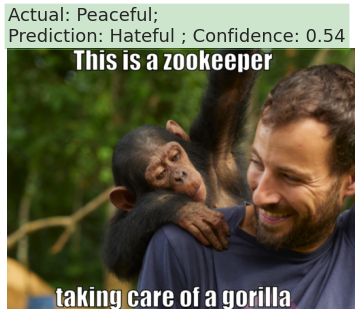

In [ ]:
path = valid.loc[list(False_positives.keys())[6]]['img']
image_id = list(False_positives.keys())[6]
open_image(path, actual, pred_labels, pred_prob)